# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import mlflow
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import optuna

from utils import *
from constants import LEAD_TIME
import warnings
warnings.simplefilter(action='ignore')


# Read data

In [45]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
train_data["DATE"] = pd.to_datetime(train_data["DATE"])
test_data["DATE"] = pd.to_datetime(test_data["DATE"])

# select random skus to plot

In [17]:
number_skus = 10
random_skus = np.random.choice(test_data['SKU'].unique(), size=number_skus, replace=False)
features = ['target_last_year',
       'target_last_lead_time', 'lag_1_year', 'lag_1_month', 'lag_3_days',
       'lag_1_day', 'moving_avg_last_2_month', 'moving_avg_last_month',
       'moving_avg_last_3_days', 'moving_avg_last_5_days',
       'moving_avg_last_10_days', 'moving_avg_last_year', 'month', 'week', 
       'global_moving_avg_last_month',
       'global_lag_last_month', 'global_moving_avg_3_days',
       'global_lag_3_days', 'global_lag_1_day', 'global_moving_avg_last_week']
target = "target"
max_train_date = train_data.DATE.max()

# Initialize mlflow

In [5]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("exp_SKU_forecast")

2024/06/02 19:38:54 INFO mlflow.tracking.fluent: Experiment with name 'exp_SKU_forecast' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/3', creation_time=1717357134034, experiment_id='3', last_update_time=1717357134034, lifecycle_stage='active', name='exp_SKU_forecast', tags={}>

In [7]:
train_data

,DATE,SKU,QUANTITY_SOLD,target,target_last_year,target_last_lead_time,lag_1_year,lag_1_month,lag_3_days,lag_1_day,...,moving_avg_last_year,month,week,global_sum_qty,global_moving_avg_last_month,global_lag_last_month,global_moving_avg_3_days,global_lag_3_days,global_lag_1_day,global_moving_avg_last_week
0,2018-01-30,-8978812568880224668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1,5,512.0,512.0,512.0,512.0,512.0,512.0,512.0
1,2018-01-31,-8978812568880224668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1,5,354.0,354.0,354.0,354.0,354.0,354.0,354.0
2,2018-02-01,-8978812568880224668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2,5,667.0,667.0,667.0,667.0,667.0,667.0,667.0
3,2018-02-02,-8978812568880224668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2,5,430.0,430.0,430.0,430.0,430.0,430.0,430.0
4,2018-02-03,-8978812568880224668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2,5,175.0,175.0,175.0,175.0,175.0,175.0,175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477035,2023-04-19,9191826166580132594,0.0,26.0,0.0,17.0,0.0,0.0,0.0,0.0,...,0.172603,4,16,4470.0,4470.0,4470.0,4470.0,4470.0,4470.0,4470.0
4477036,2023-04-20,9191826166580132594,1.0,25.0,0.0,18.0,0.0,0.0,0.0,0.0,...,0.175342,4,16,4982.0,4982.0,4982.0,4982.0,4982.0,4982.0,4982.0
4477037,2023-04-21,9191826166580132594,1.0,24.0,0.0,19.0,0.0,0.0,0.0,1.0,...,0.178082,4,16,5537.0,5537.0,5537.0,5537.0,5537.0,5537.0,5537.0
4477038,2023-04-22,9191826166580132594,0.0,25.0,0.0,19.0,0.0,0.0,0.0,1.0,...,0.178082,4,16,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0


# Benchmark approach: Moving_average

Mean absolute error on model is 48.9993

The r2 score on model is 0.1534


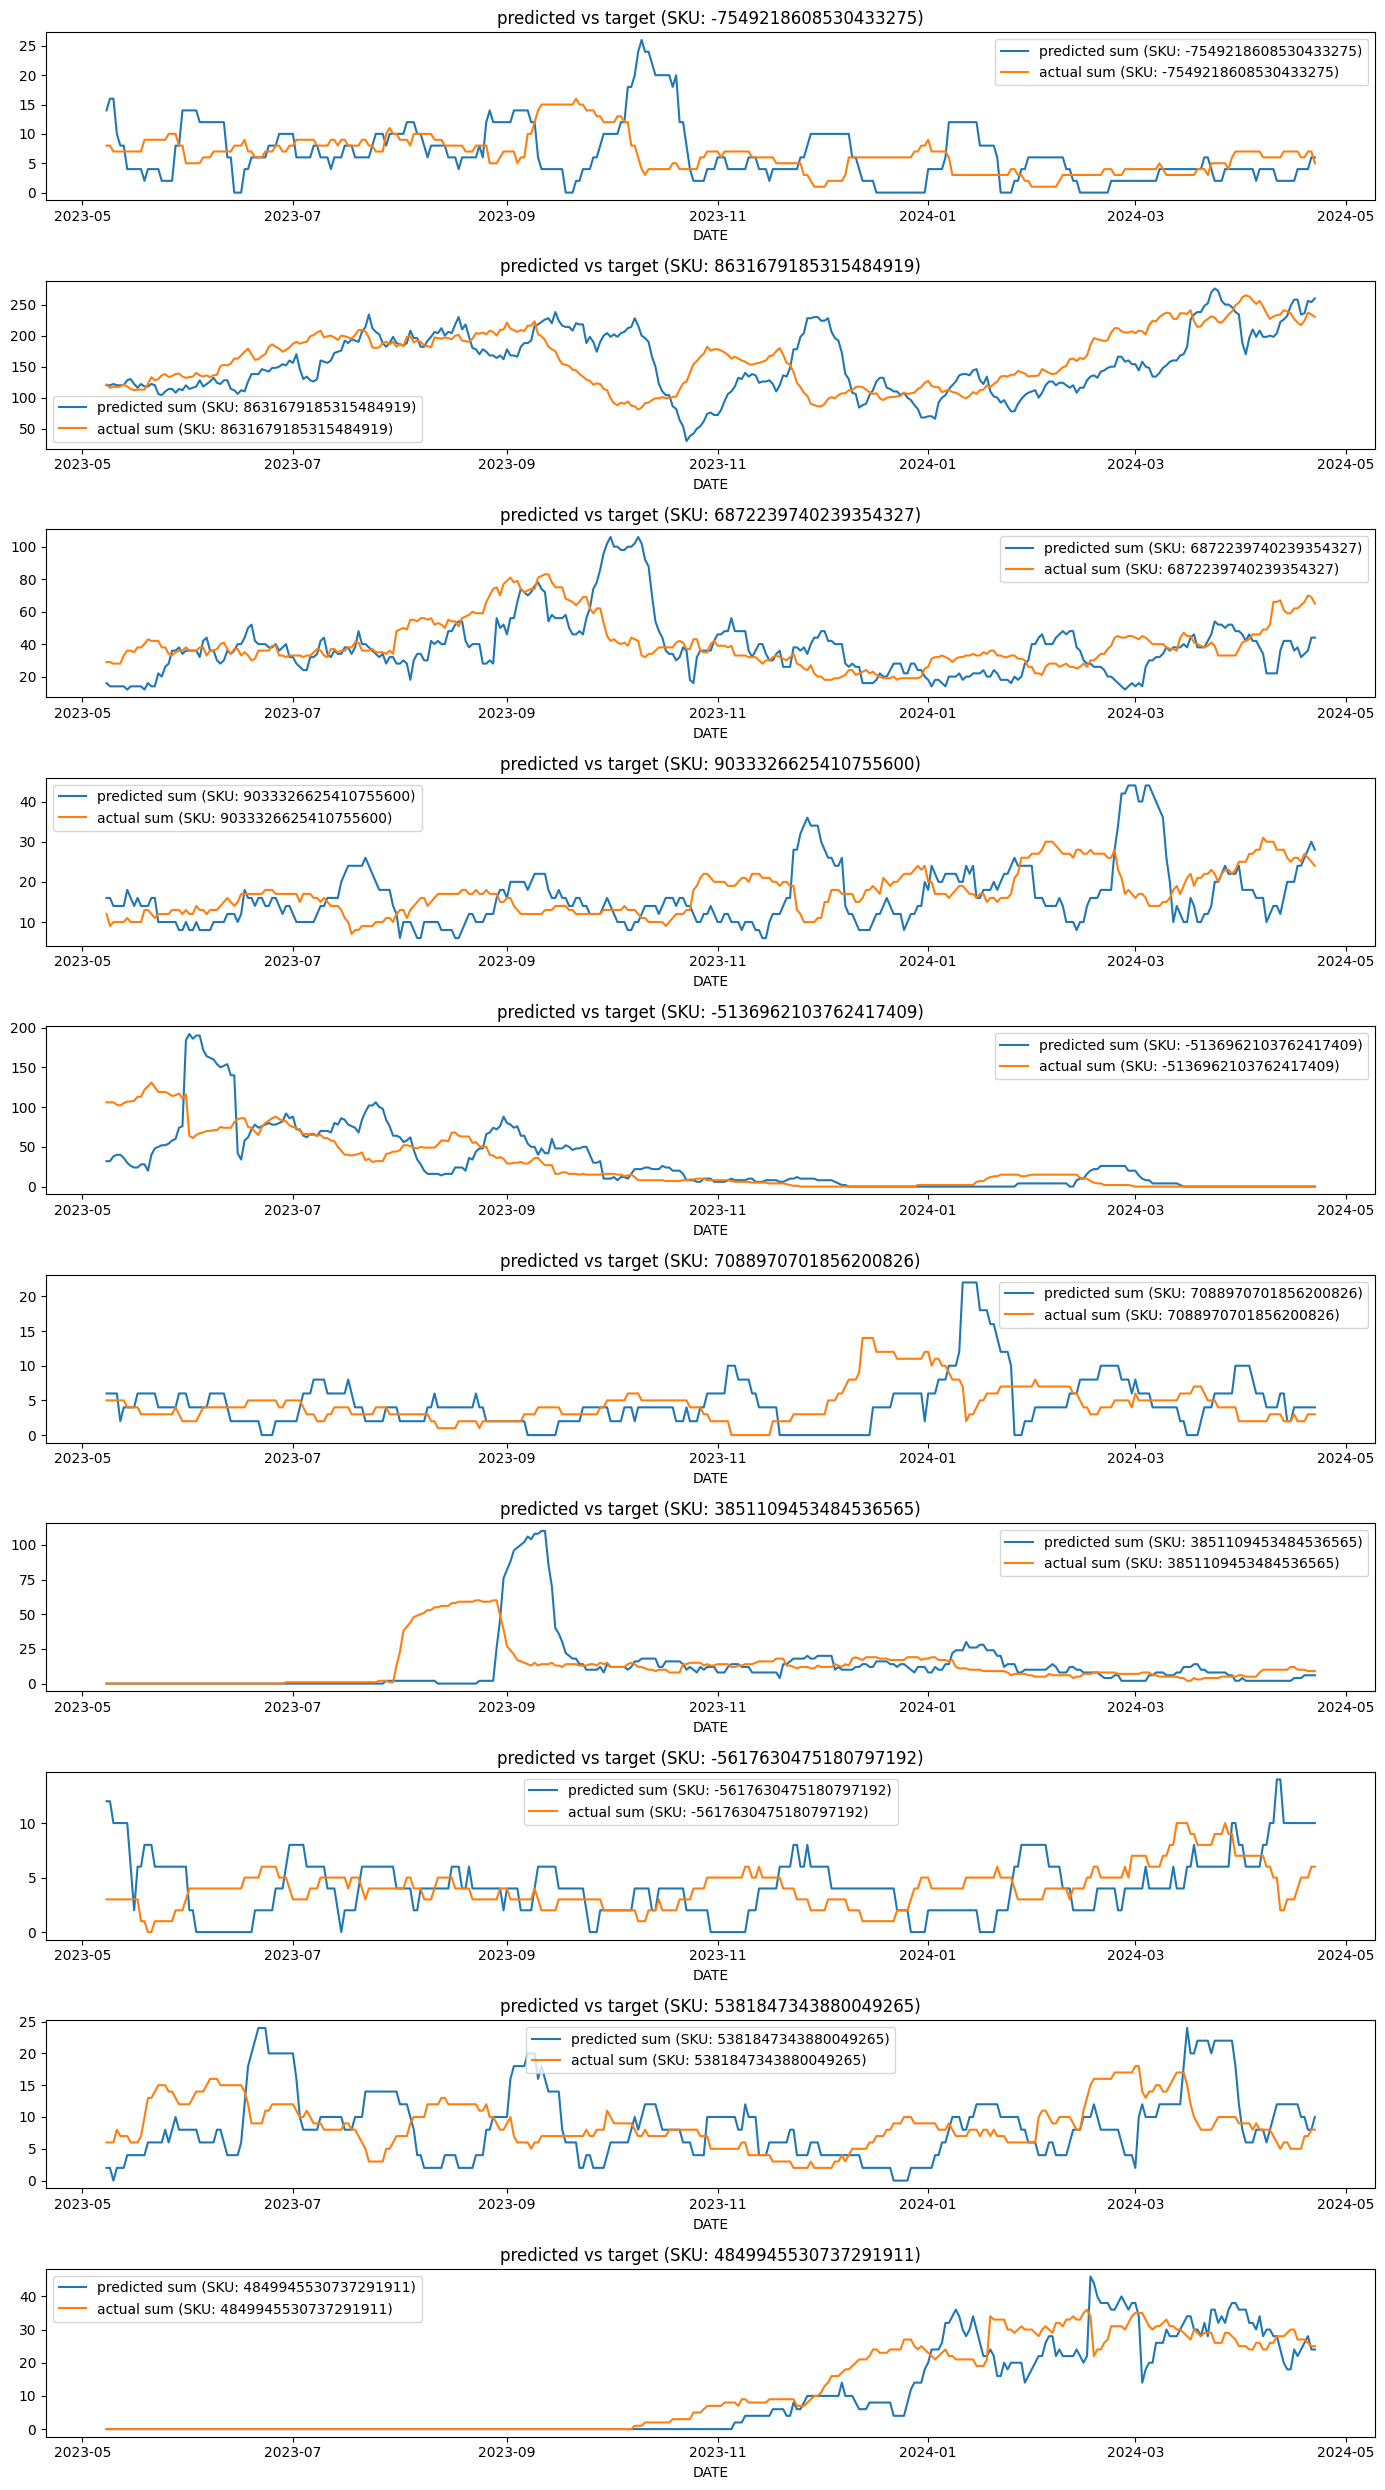

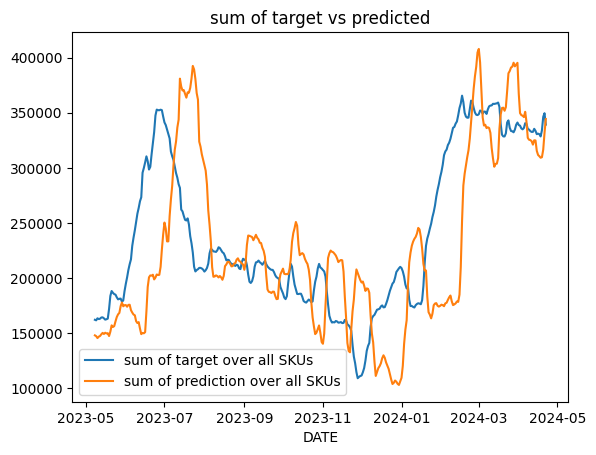

In [27]:
LAG = 15
def moving_average_model(data, lag, lead_time):
    data['prediction'] = (data.groupby('SKU')['QUANTITY_SOLD'].transform(lambda x: x.shift(-1).rolling(window=lag).mean())) * lead_time
    return data.dropna(subset=['prediction'])


with mlflow.start_run(run_name="moving_average_model"):
    data_ma = test_data.copy()
    data_ma = moving_average_model(data_ma, LAG, LEAD_TIME)

    target_test = data_ma['target']
    predictions_test = data_ma['prediction']
    mae_test, r2_test = modelresults(target_test, predictions_test)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Monitoring for selected SKUs
    fig, axes = plt.subplots(nrows=number_skus, ncols=1, figsize=(14, 25))

    for i, sku in enumerate(random_skus):
        sku_test_data = data_ma[data_ma['SKU'] == sku]
        ax = axes[i]
        ax.plot(sku_test_data['DATE'], sku_test_data['prediction'], label=f'predicted sum (SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data['target'], label=f'actual sum (SKU: {sku})')

        ax.set_title(f'predicted vs target (SKU: {sku})')
        ax.set_xlabel('DATE')
        ax.legend()

    plt.tight_layout()
    plt.savefig("sku_predictions.png")
    plt.show()

    mlflow.log_artifact("sku_predictions.png")

    # Plot sum of target vs predicted over all SKUs
    sum_target_all = data_ma.groupby('DATE')['target'].sum()
    plt.plot(sum_target_all.index, sum_target_all, label='sum of target over all SKUs')

    sum_moving_avg_all = data_ma.groupby('DATE')['prediction'].sum()
    plt.plot(sum_moving_avg_all.index, sum_moving_avg_all, label='sum of prediction over all SKUs')

    plt.title('sum of target vs predicted')
    plt.xlabel('DATE')
    plt.legend()
    plt.savefig("sum_target_vs_predicted.png")
    plt.show()

    mlflow.log_artifact("sum_target_vs_predicted.png")

# Xgboost

## create validation_set and hyperparameter tuning

In [28]:


# construct a validation_set of the last 8 months of the train data
split_date = max_train_date - pd.DateOffset(months=8)

train_set = train_data[train_data['DATE'] < split_date].copy()
val_set = train_data[train_data['DATE'] >= split_date].copy()



def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150 ),
        'max_depth': trial.suggest_int('max_depth', 4, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 1.0, 0.1),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'objective': 'reg:squarederror',
        'eval_metric': 'mae'  
    }

    
    xgb_model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    xgb_model.fit(train_set[features], train_set[target])

    predictions = xgb_model.predict(val_set[features])

    mae = mean_absolute_error(val_set[target], predictions)
    r2 = r2_score(val_set[target], predictions)

    with mlflow.start_run(nested=True):
        for key, value in params.items():
            mlflow.log_param(key, value)
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('r2', r2)

    return mae

n_trials = 20  

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-06-02 19:46:07,886] A new study created in memory with name: no-name-5d422e9c-b839-424f-91f9-ee58c0e66fde
[I 2024-06-02 19:48:02,910] Trial 0 finished with value: 16.382683662560474 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.027969721140924695, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.0066764958986310526, 'lambda': 0.0017141343694504821, 'alpha': 0.020706006634041842}. Best is trial 0 with value: 16.382683662560474.
[I 2024-06-02 19:50:31,518] Trial 1 finished with value: 19.287009890076778 and parameters: {'n_estimators': 99, 'max_depth': 7, 'learning_rate': 0.011425899278995715, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 0.0035839043027408855, 'lambda': 0.004138786183229327, 'alpha': 0.593090919236897}. Best is trial 0 with value: 16.382683662560474.
[I 2024-06-02 19:52:36,040] Trial 2 finished with value: 16.36682674775801 and parameters: {'n_estimators': 73, 'max_depth': 7, 'learning_rate': 0.03894542511240535, 'subsample':

Best Hyperparameters: {'n_estimators': 108, 'max_depth': 4, 'learning_rate': 0.02398851581330047, 'subsample': 0.7, 'colsample_bytree': 0.8, 'gamma': 0.016757305395212613, 'lambda': 0.22006752661306744, 'alpha': 0.052719165534926}


## train model with best hyperparameters

Mean absolute error on model is 45.6976

The r2 score on model is 0.4050


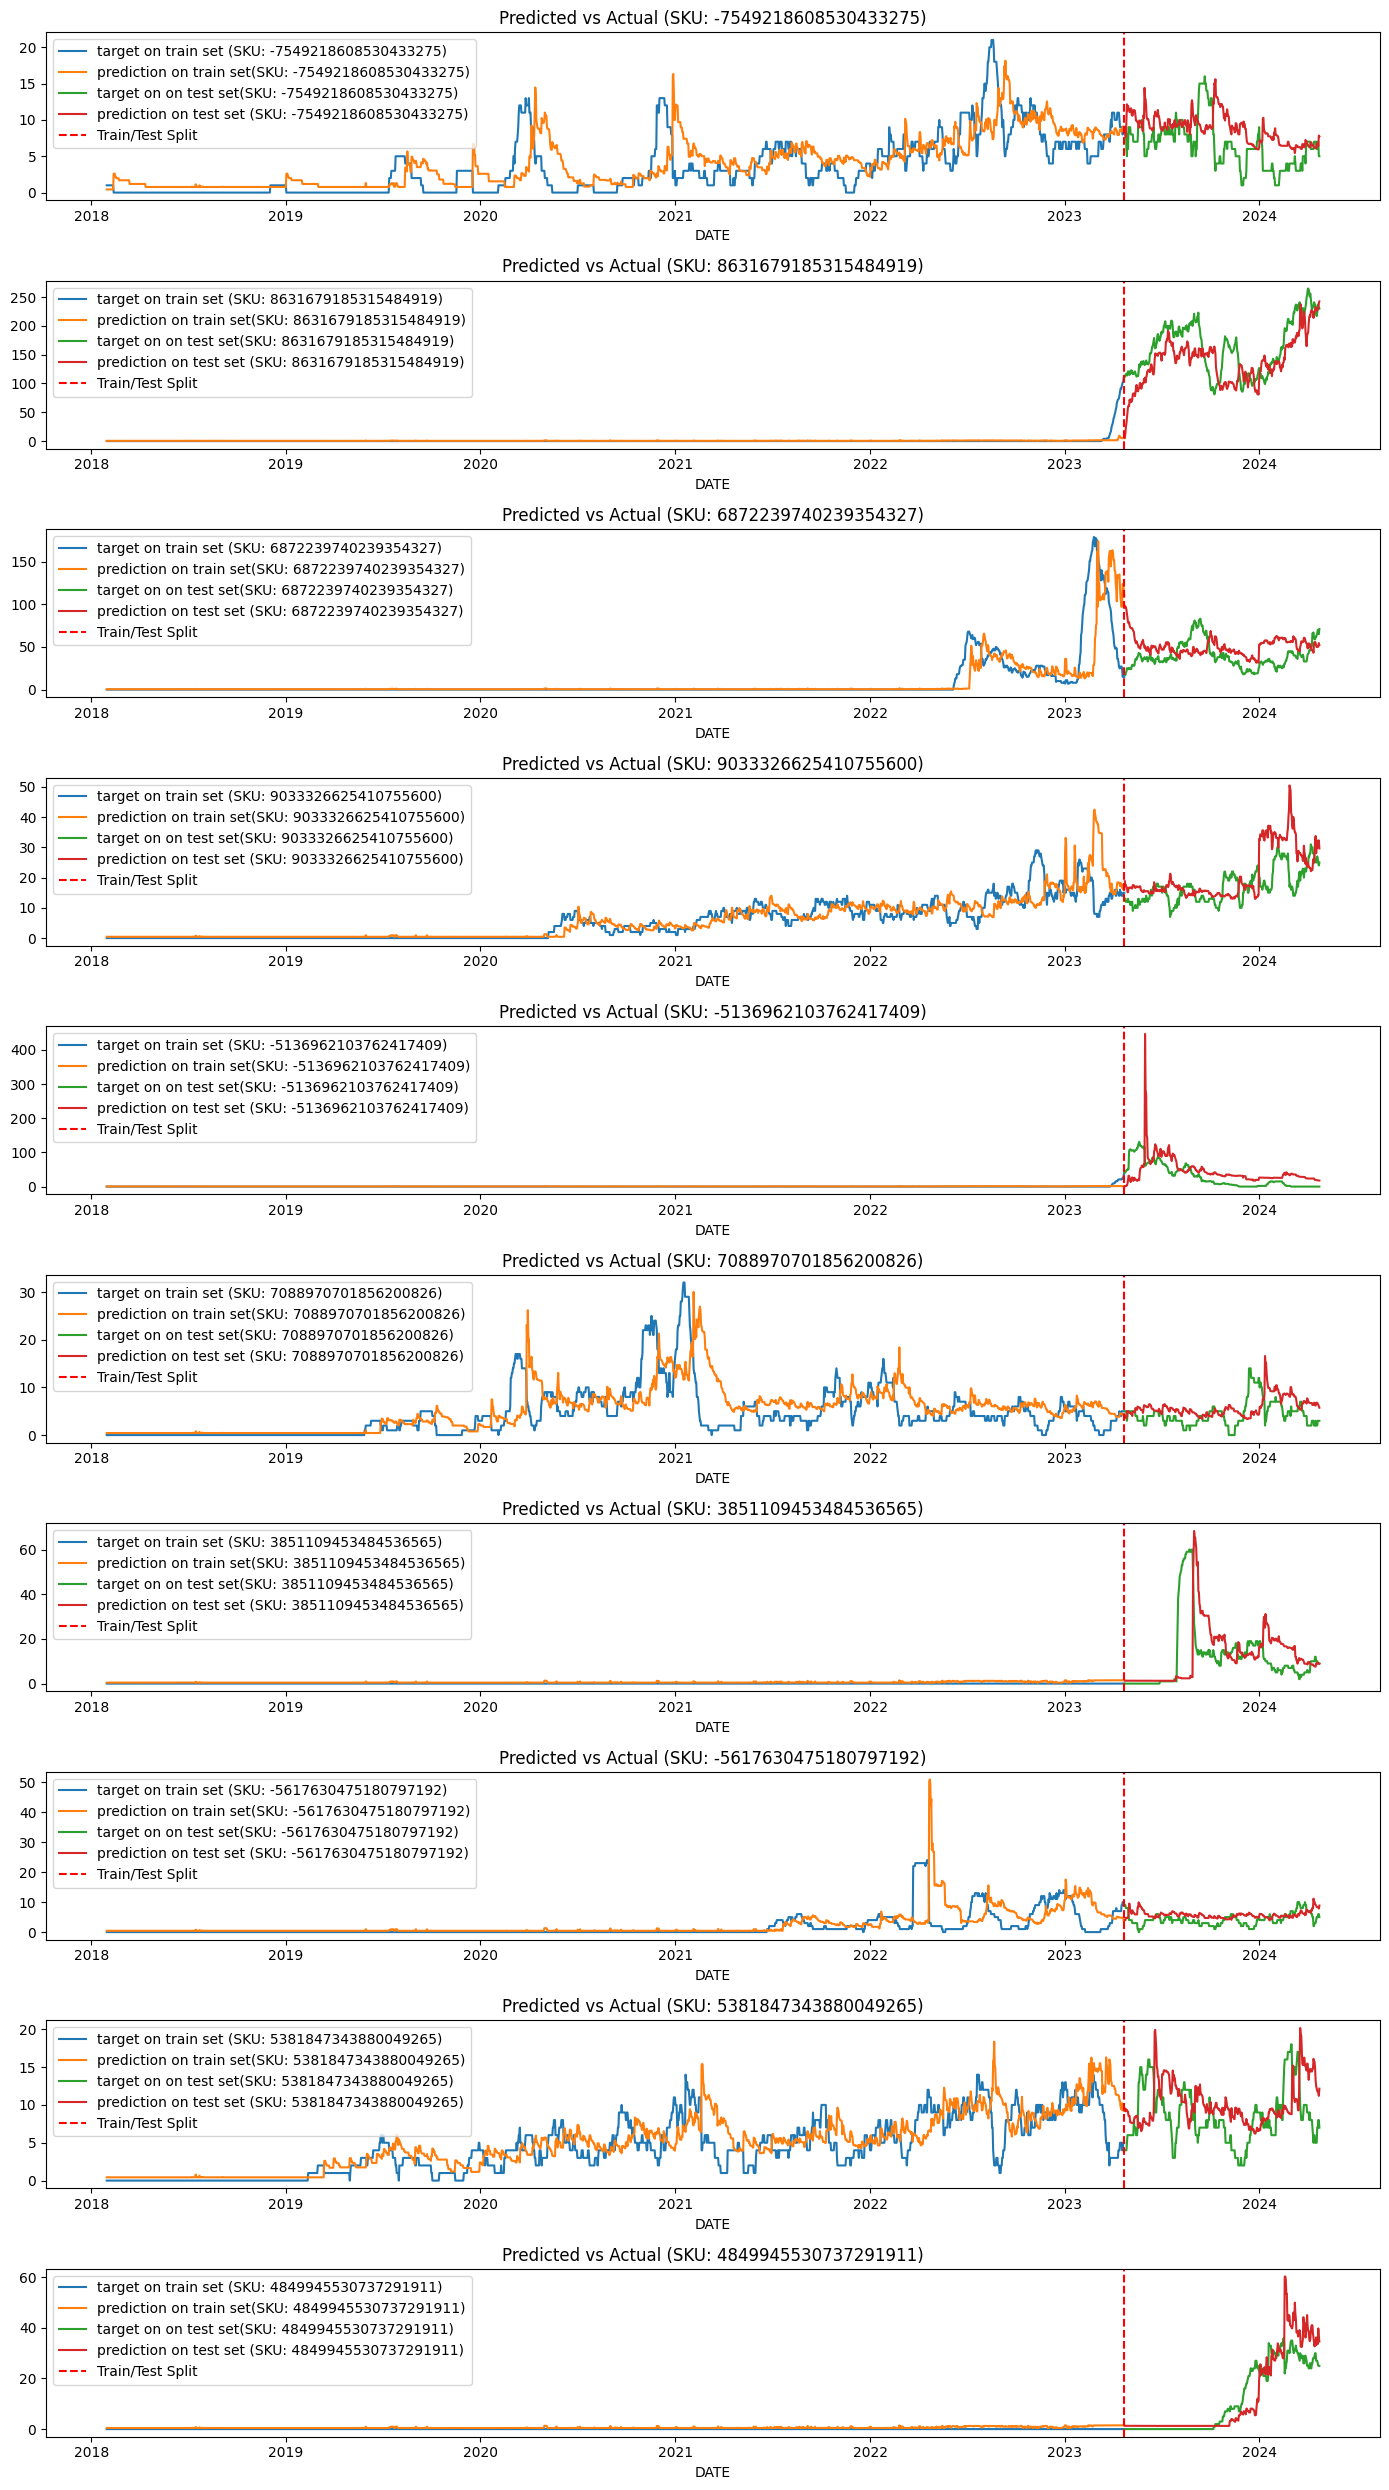

In [38]:
with mlflow.start_run(run_name="XGBoost"):
    
    # train model
    xgb_model = xgb.XGBRegressor(**best_params)
    xgb_model.fit(train_data[features], train_data["target"])

    # evaluate model
    predictions_train = xgb_model.predict(train_data[features])
    predictions_test = xgb_model.predict(test_data[features])
    
    target_train = train_data["target"]
    target_test = test_data["target"]
    mae_test, r2_test = modelresults(target_test, predictions_test)

    # log metrics with MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric('mae', mae_test)
    mlflow.log_metric('r2', r2_test)

    evaluated_train = train_data.copy()
    evaluated_test = test_data.copy()
    evaluated_train["prediction"] = predictions_train
    evaluated_test["prediction"] = predictions_test
    max_date_train = train_data["DATE"].max()
    # monitoring over selected SKUs
    fig, axes = plt.subplots(nrows=number_skus, ncols=1, figsize=(14, 25))
    for i, sku in enumerate(random_skus):
        sku_train_data = evaluated_train[evaluated_train['SKU'] == sku]
        sku_test_data = evaluated_test[evaluated_test['SKU'] == sku]
        
        ax = axes[i]
        ax.plot(sku_train_data["DATE"], sku_train_data["target"], label=f'target on train set (SKU: {sku})')
        ax.plot(sku_train_data["DATE"], sku_train_data["prediction"], label=f'prediction on train set(SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data["target"], label=f'target on on test set(SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data["prediction"], label=f'prediction on test set (SKU: {sku})')
        
        ax.axvline(max_date_train, color='r', linestyle='--', label='Train/Test Split')

        ax.set_title(f'Predicted vs Actual (SKU: {sku})')
        ax.set_xlabel('DATE')
        ax.legend()
    plt.tight_layout()
    plt.savefig("sku_predictions_xgb.png")
    plt.show()
    
    mlflow.log_artifact("sku_predictions_xgb.png")

We notice that the model training takes too long because of the quantity of the data, and it overfits a lot on the training set. 
As the data is very scarce, most of the values are 0, we try to balance our train set by sampling from the SKUs that hasn't been sold on the last month

# Xgboost with sampling 

## sample and balance data 

In [33]:
train_data_sample = train_data.copy()

# sample 20% of the data that hasn't been sold over last month
zero_sale_data = train_data_sample[train_data_sample['moving_avg_last_month'] == 0]
non_zero_sale_data = train_data_sample[train_data_sample['moving_avg_last_month'] != 0]

sampled_zero_sale_data = zero_sale_data.sample(frac=0.2, random_state=42)

balanced_train_data = pd.concat([non_zero_sale_data, sampled_zero_sale_data])


# split into train validation
max_date = balanced_train_data['DATE'].max()

split_date = max_date - pd.DateOffset(months=8)

train_set = balanced_train_data[balanced_train_data['DATE'] < split_date]
val_set = balanced_train_data[balanced_train_data['DATE'] >= split_date]

## hyperparameter optimization

In [34]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 1.0, 0.1),
        'gamma': trial.suggest_loguniform('gamma', 1e-6, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-6, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'mae'  # Mean Absolute Error as the evaluation metric
    }

    # Train XGBoost model
    xgb_model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    xgb_model.fit(train_set[features], train_set[target])

    # Predict on validation set
    predictions = xgb_model.predict(val_set[features])

    # Evaluate model
    mae = mean_absolute_error(val_set[target], predictions)
    r2 = r2_score(val_set[target], predictions)

    # Log metrics with MLflow
    with mlflow.start_run(nested=True):
        for key, value in params.items():
            mlflow.log_param(key, value)
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('r2', r2)

    return mae

# Define parameters
n_trials = 20  # Number of trials for hyperparameter optimization

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Get best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-06-02 20:47:48,345] A new study created in memory with name: no-name-0016df64-0568-490d-af17-8e12da47efcf
[I 2024-06-02 20:48:26,485] Trial 0 finished with value: 23.358785474602364 and parameters: {'n_estimators': 63, 'max_depth': 7, 'learning_rate': 0.09191054952191469, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.00028592091742188645, 'lambda': 0.34338010958343357, 'alpha': 0.16089213546300102}. Best is trial 0 with value: 23.358785474602364.
[I 2024-06-02 20:49:03,887] Trial 1 finished with value: 22.385935637337848 and parameters: {'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.04581950503423346, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 2.065711651638364e-05, 'lambda': 0.023458948454029602, 'alpha': 0.9391251196721593}. Best is trial 1 with value: 22.385935637337848.
[I 2024-06-02 20:50:11,480] Trial 2 finished with value: 23.05634935754525 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.023914339142278373, 'subsample': 0

Best Hyperparameters: {'n_estimators': 81, 'max_depth': 6, 'learning_rate': 0.03707824028156351, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 0.018309512586500896, 'lambda': 0.00018860129880107608, 'alpha': 0.002293722691755294}


In [58]:
best_params

{'n_estimators': 81,
 'max_depth': 6,
 'learning_rate': 0.03707824028156351,
 'subsample': 0.9,
 'colsample_bytree': 0.6,
 'gamma': 0.018309512586500896,
 'lambda': 0.00018860129880107608,
 'alpha': 0.002293722691755294}

## model training and evaluation

Mean absolute error on model is 44.6990

The r2 score on model is 0.4267


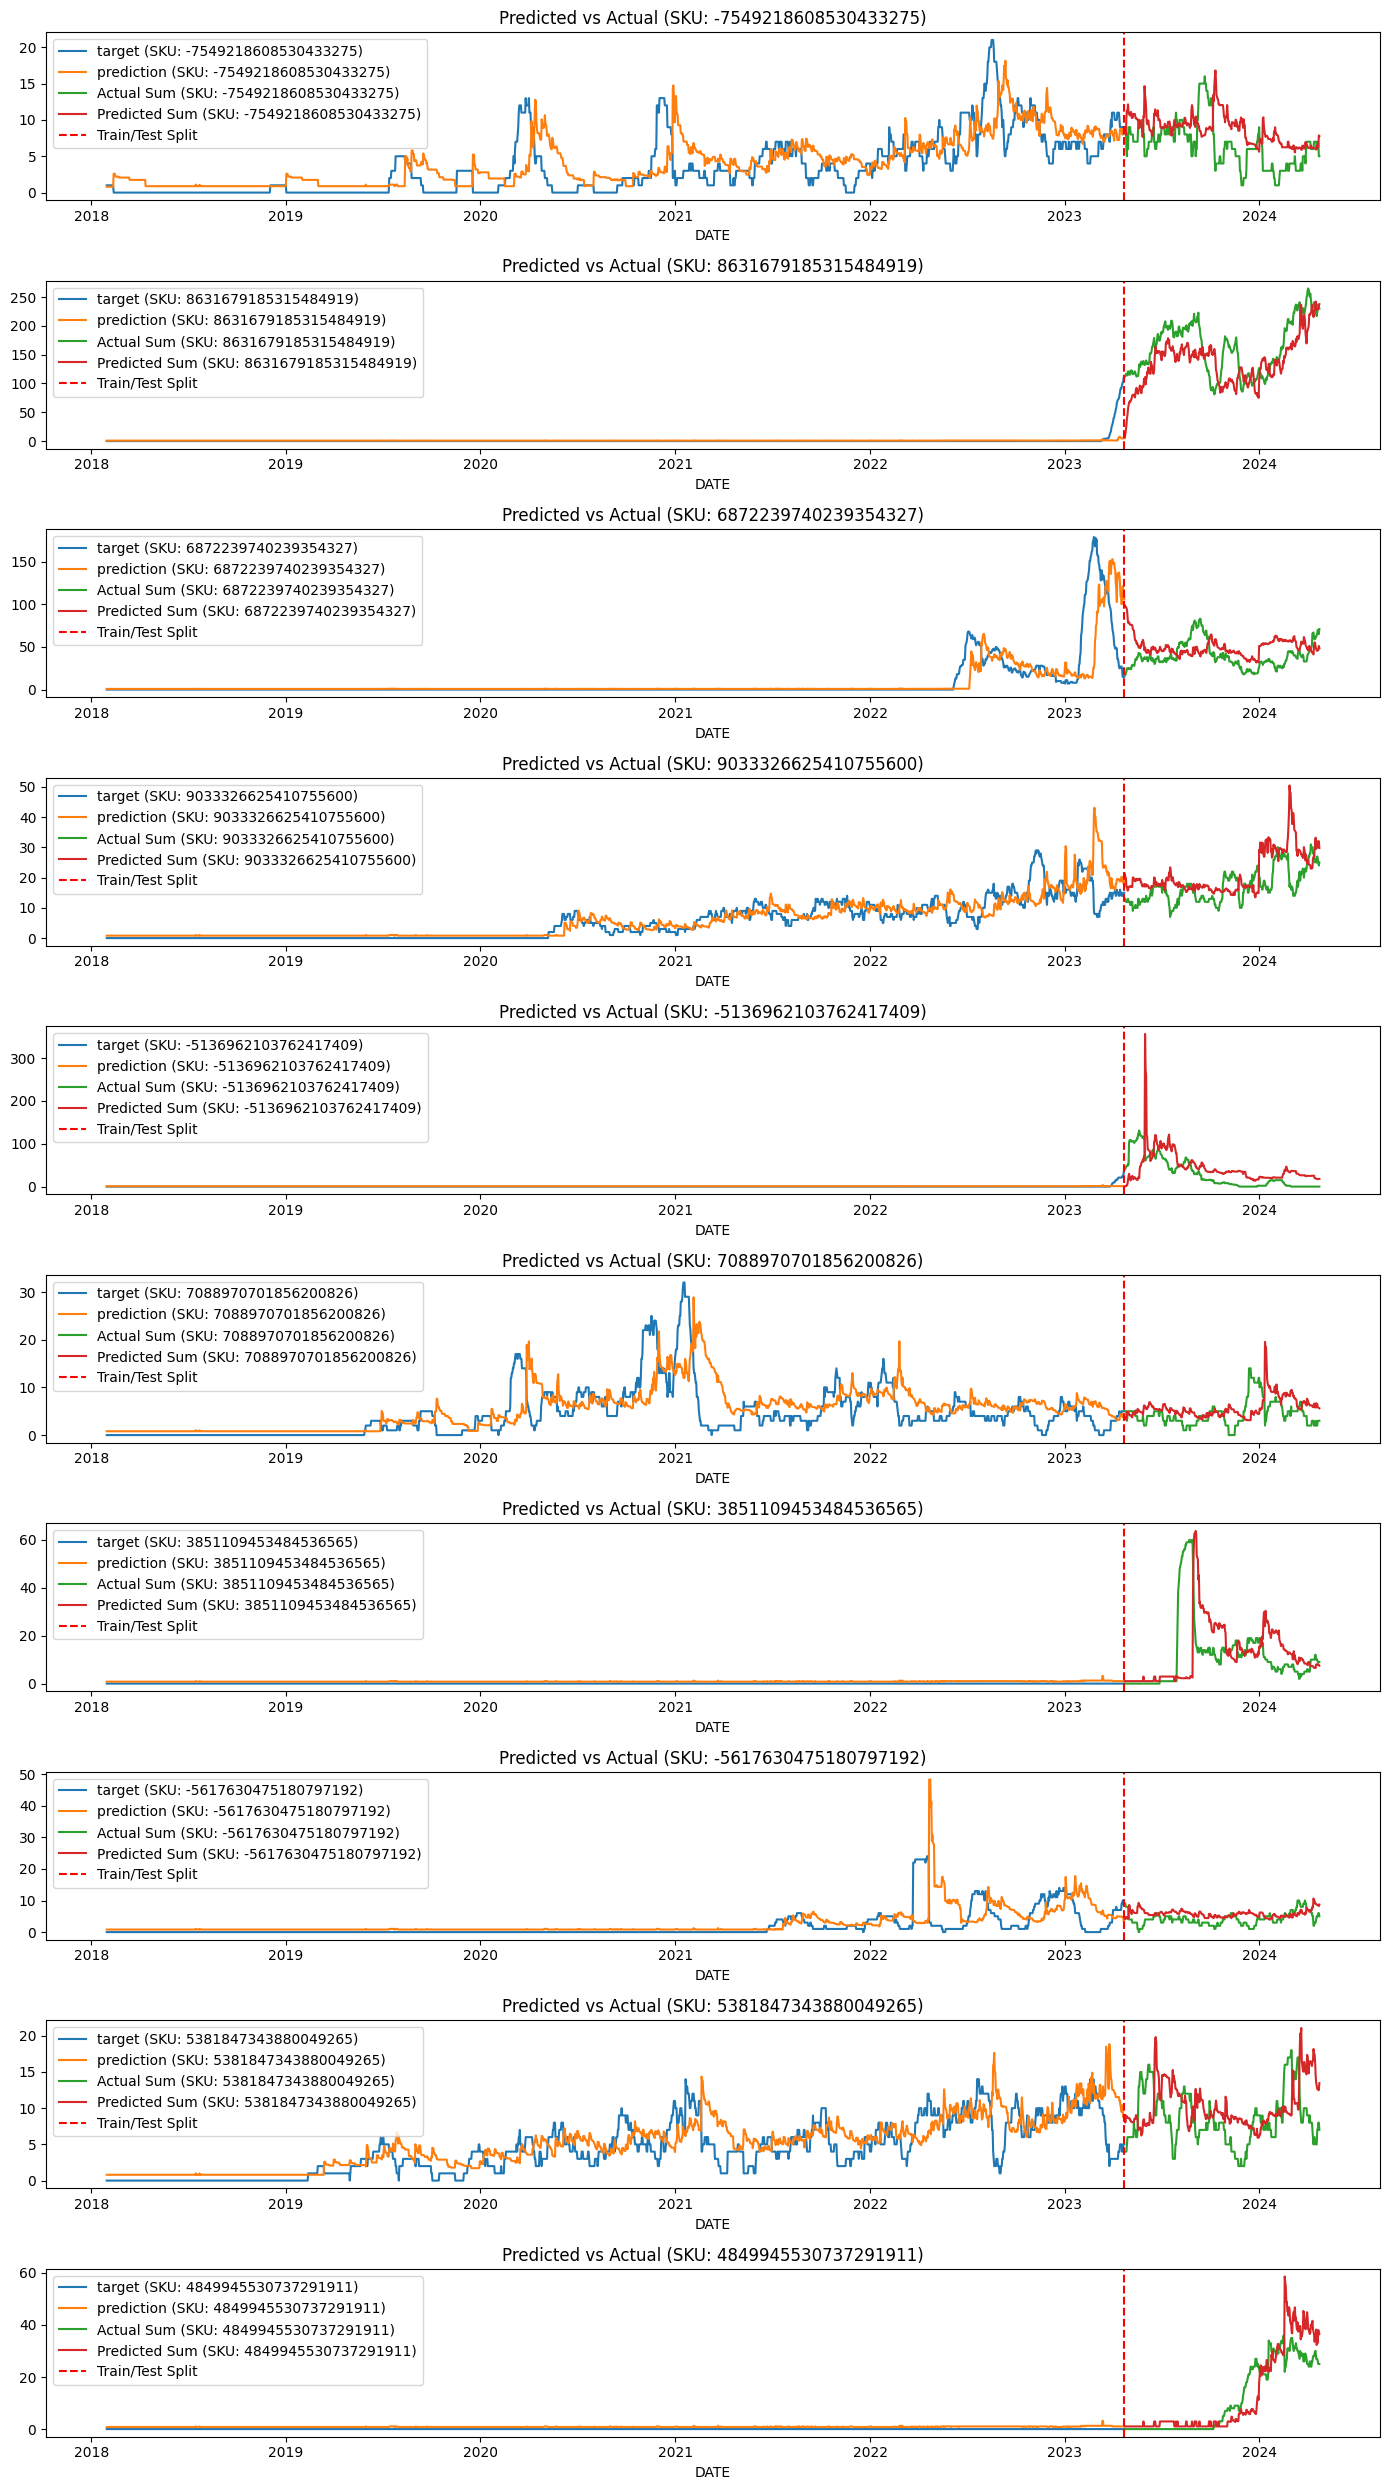

In [43]:
with mlflow.start_run(run_name="XGBoost_sampled"):
    
    # train model
    xgb_model = xgb.XGBRegressor(**best_params)
    xgb_model.fit(balanced_train_data[features], balanced_train_data["target"])

    # evaluate model
    predictions_train = xgb_model.predict(train_data[features])
    predictions_test = xgb_model.predict(test_data[features])
    
    target_train = train_data["target"]
    target_test = test_data["target"]
    mae_test, r2_test = modelresults(target_test, predictions_test)


    # log metrics with MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric('mae', mae_test)
    mlflow.log_metric('r2', r2_test)

    evaluated_train = train_data.copy()
    evaluated_test = test_data.copy()
    evaluated_train["prediction"] = predictions_train
    evaluated_test["prediction"] = predictions_test
    max_date_train = train_data["DATE"].max()
    # monitoring over selected SKUs
    fig, axes = plt.subplots(nrows=number_skus, ncols=1, figsize=(14, 25))
    for i, sku in enumerate(random_skus):
        sku_train_data = evaluated_train[evaluated_train['SKU'] == sku]
        sku_test_data = evaluated_test[evaluated_test['SKU'] == sku]
        
        ax = axes[i]
        ax.plot(sku_train_data["DATE"], sku_train_data["target"], label=f'target (SKU: {sku})')
        ax.plot(sku_train_data["DATE"], sku_train_data["prediction"], label=f'prediction (SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data["target"], label=f'Actual Sum (SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data["prediction"], label=f'Predicted Sum (SKU: {sku})')
        
        ax.axvline(max_date_train, color='r', linestyle='--', label='Train/Test Split')

        ax.set_title(f'Predicted vs Actual (SKU: {sku})')
        ax.set_xlabel('DATE')
        ax.legend()
    plt.tight_layout()
    plt.savefig("sku_predictions_xgb.png")
    plt.show()
    
    mlflow.log_artifact("sku_predictions_xgb.png")

We see that the model on sampled data performs better but we still have big variance in the output, xgboost doesn't consider time linearity and predict for each date independently, this will require us to apply smoothing on the output

## Xgboost with sampling and exponential moving average smoothing

Mean absolute error on model is 44.7960

The r2 score on model is 0.4224


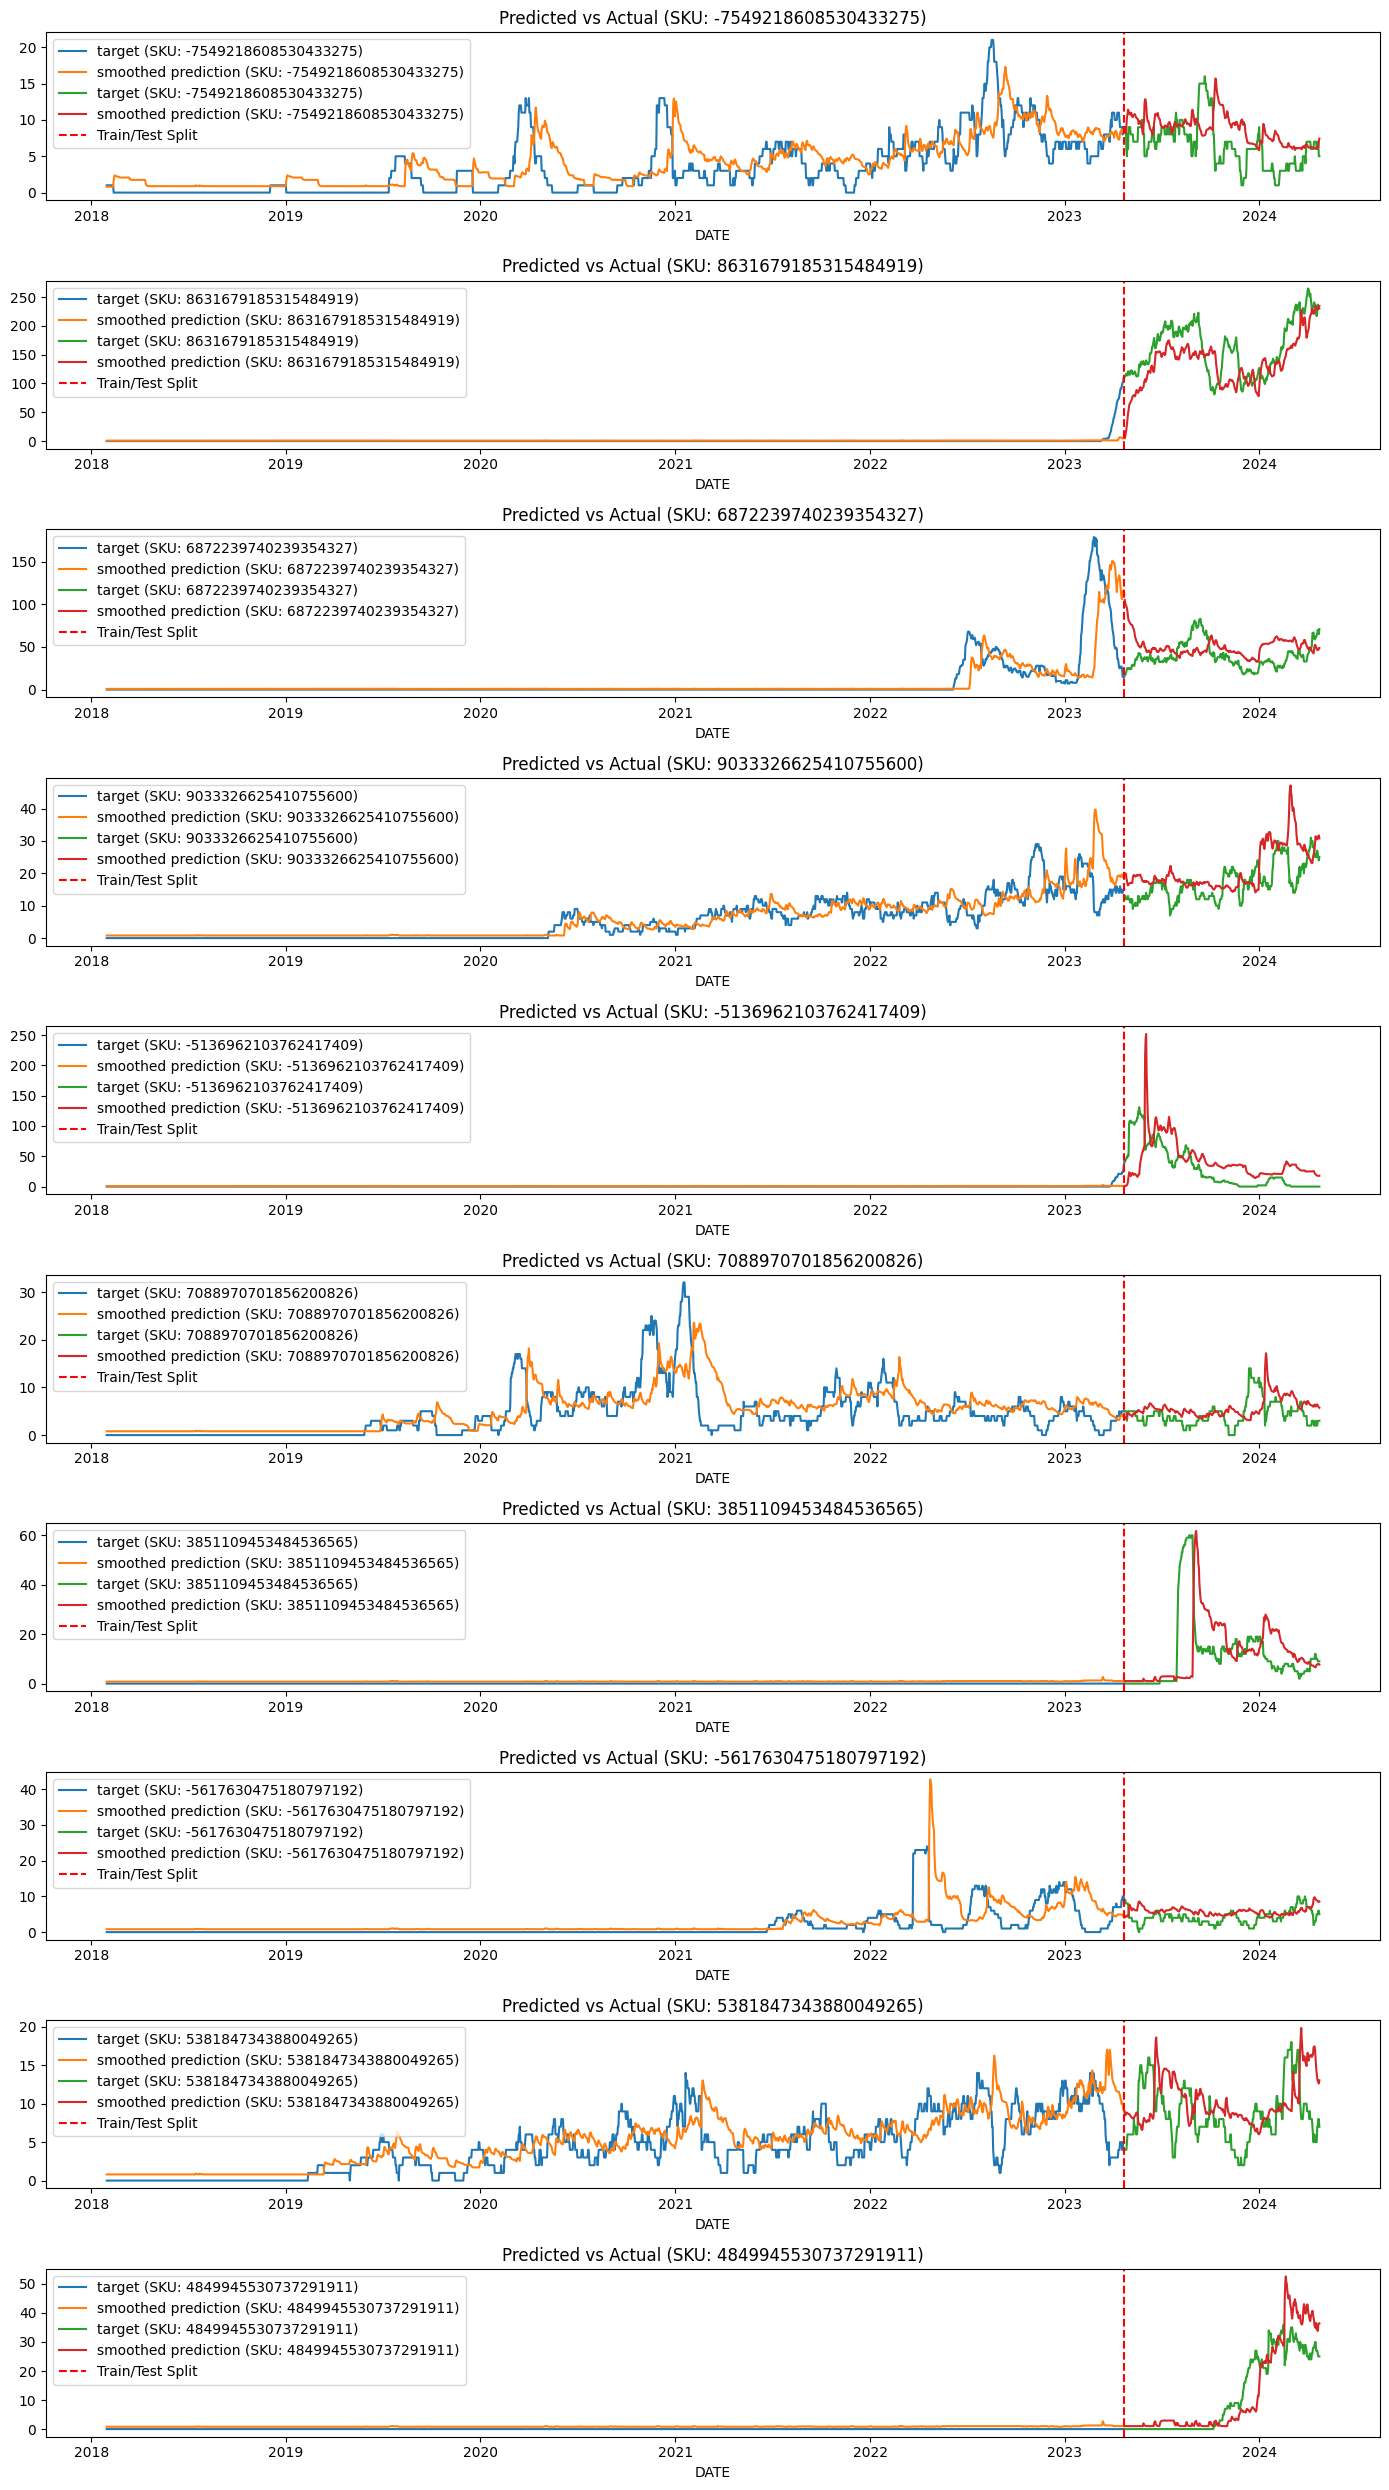

In [56]:
with mlflow.start_run(run_name="XGBoost_sampled_smoothed"):

    predictions_train = xgb_model.predict(train_data[features])
    target_train = train_data["target"]
    predictions_test = xgb_model.predict(test_data[features])
    target_test = test_data["target"]
    
    evaluated_train["prediction"] = predictions_train
    evaluated_test["prediction"] = predictions_test

    # combine train and test datasets
    evaluated_train['is_train'] = True
    evaluated_test['is_train'] = False
    full_data = pd.concat([evaluated_train, evaluated_test])
    full_data = full_data.sort_values(by=['SKU', 'DATE'])

    # apply smoothing to predictions by SKU
    full_data['smoothed_predictions'] = full_data.groupby('SKU')['prediction'].transform(lambda x: x.ewm(span=3, adjust=False).mean())
    # split the data back into train and test sets
    train_data = full_data[full_data['is_train']].drop(columns=['is_train'])
    test_data = full_data[full_data['is_train'] == False].drop(columns=['is_train'])

    mae_test, r2_test = modelresults(test_data["target"], test_data['smoothed_predictions'])

    # mog metrics with MLflow
    mlflow.log_params(best_params)

    mlflow.log_metric('mae', mae_test)
    mlflow.log_metric('r2', r2_test)


    # Monitoring for selected SKUs
    fig, axes = plt.subplots(nrows=number_skus, ncols=1, figsize=(14, 25))
    for i, sku in enumerate(random_skus):
        sku_train_data = train_data[train_data['SKU'] == sku]
        sku_test_data = test_data[test_data['SKU'] == sku]
        
        ax = axes[i]
        ax.plot(sku_train_data["DATE"], sku_train_data["target"], label=f'target (SKU: {sku})')
        ax.plot(sku_train_data["DATE"], sku_train_data["smoothed_predictions"], label=f'smoothed prediction (SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data["target"], label=f'target (SKU: {sku})')
        ax.plot(sku_test_data['DATE'], sku_test_data["smoothed_predictions"], label=f'smoothed prediction (SKU: {sku})')
        
        ax.axvline(max_date_train, color='r', linestyle='--', label='Train/Test Split')

        ax.set_title(f'Predicted vs Actual (SKU: {sku})')
        ax.set_xlabel('DATE')
        ax.legend()
    plt.tight_layout()
    plt.savefig("sku_predictions_xgb.png")
    plt.show()
    
    mlflow.log_artifact("sku_predictions_xgb.png")

The smoothing doesn't improve the metric but improves the quality of the model as we can

## explainability

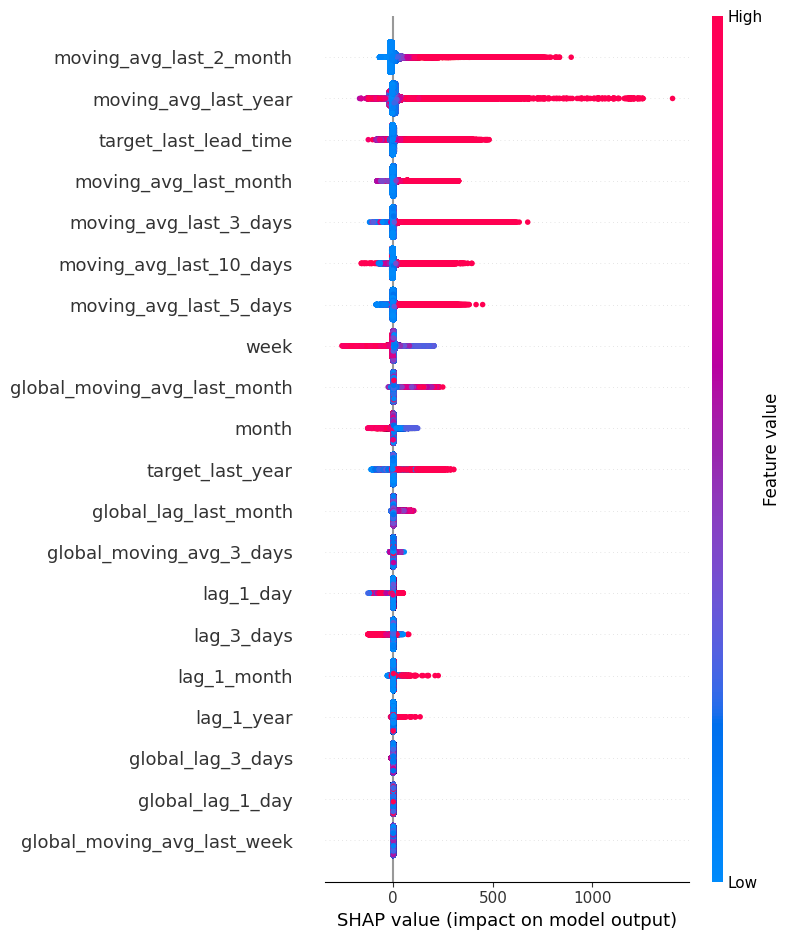

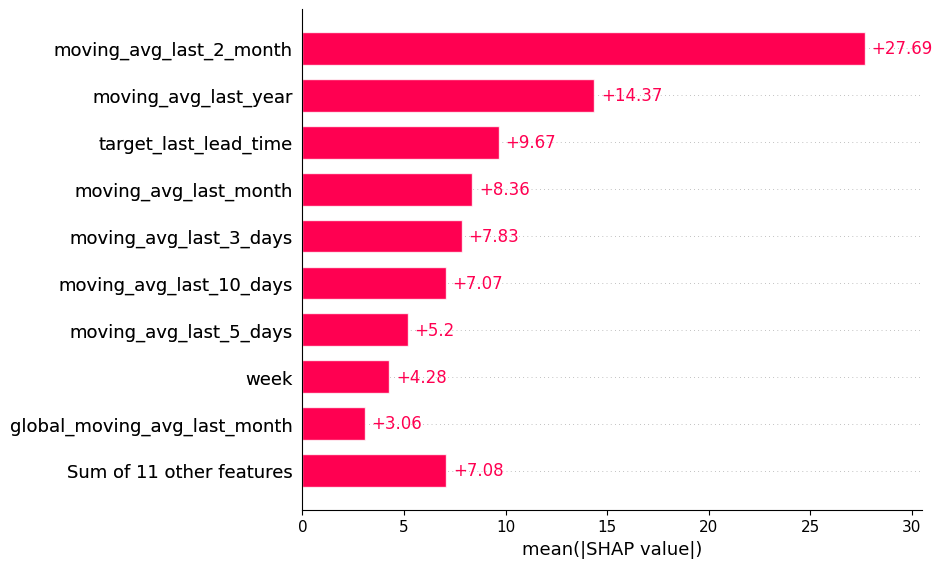

In [57]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt


explainer = shap.Explainer(xgb_model)
shap_values = explainer(test_data[features])

shap.summary_plot(shap_values, test_data[features])

shap.plots.bar(shap_values)

In [59]:
best_params

{'n_estimators': 81,
 'max_depth': 6,
 'learning_rate': 0.03707824028156351,
 'subsample': 0.9,
 'colsample_bytree': 0.6,
 'gamma': 0.018309512586500896,
 'lambda': 0.00018860129880107608,
 'alpha': 0.002293722691755294}